In [1]:
import scipy.sparse as sparse
import scipy.linalg as linalg
import scipy.fftpack as fft
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set_style('whitegrid')

In [2]:
if __name__ == '__main__':
    shape = (3, 3)
    nx, ny = shape

    charges = np.zeros(shape)
    charges[:] = 1.0 / (nx * ny)
    charges[nx / 2, ny / 2] = 1.0 / (nx * ny) - 1.0
    print charges

    charges = charges.flatten()

#Build Laplacian
    ex  = np.append(np.ones(nx - 2), [2, 2])
    ey  = np.append(np.ones(ny - 2), [2, 2])
    Dxx = sparse.spdiags([ex, -2 * np.ones(nx), ex[::-1]], [-1, 0, 1], nx, nx)
    Dyy = sparse.spdiags([ey, -2 * np.ones(ny), ey[::-1]], [-1, 0, 1], ny, ny)

    L = sparse.kronsum(Dxx, Dyy).todense()
###############

#Fourier method
    rhofft = np.zeros(shape, dtype = float)
    for i in range(shape[0]):
        rhofft[i,:] = fft.dct(charges.reshape(shape)[i,:], type = 1) / (shape[1] - 1.0)
    for j in range(shape[1]):
        rhofft[:,j] = fft.dct(rhofft[:,j], type = 1) / (shape[0] - 1.0)

    for i in range(shape[0]):
        for j in range(shape[1]):
            factor = 2.0 * (np.cos((np.pi * i) / (shape[0] - 1)) + np.cos((np.pi * j) / (shape[1] - 1)) - 2.0)
            if factor != 0.0:
                rhofft[i, j] /= factor
            else:
                rhofft[i, j] = 0.0

    potential = np.zeros(shape, dtype = float)
    for i in range(shape[0]):
        potential[i,:] = 0.5 * fft.dct(rhofft[i,:], type = 1)
    for j in range(shape[1]):
        potential[:,j] = 0.5 * fft.dct(potential[:,j], type = 1)

################
    print np.dot(L, potential.flatten()).reshape(shape)
    print potential

[[ 0.11111111  0.11111111  0.11111111]
 [ 0.11111111 -0.88888889  0.11111111]
 [ 0.11111111  0.11111111  0.11111111]]
[[ 0.25  0.25  0.25]
 [ 0.25 -0.75  0.25]
 [ 0.25  0.25  0.25]]
[[-0.09375 -0.03125 -0.09375]
 [-0.03125  0.15625 -0.03125]
 [-0.09375 -0.03125 -0.09375]]


In [3]:
    rhofft = np.zeros(shape, dtype = float)
    for i in range(shape[0]):
        rhofft[i,:] = fft.dct(charges.reshape(shape)[i,:], type = 1) / (shape[1] - 1.0)
    for j in range(shape[1]):
        rhofft[:,j] = fft.dct(rhofft[:,j], type = 1) / (shape[0] - 1.0)

    for i in range(shape[0]):
        for j in range(shape[1]):
            factor = 2.0 * (np.cos((np.pi * i) / (shape[0] - 1)) + np.cos((np.pi * j) / (shape[1] - 1)) - 2.0)
            if factor != 0.0:
                rhofft[i, j] /= factor
            else:
                rhofft[i, j] = 0.0


# Analytic A and B

In [4]:
x = np.linspace(-5, 5, 500)
y = np.linspace(-5, 5, 100)

mesh = np.meshgrid(x, y)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
rho_x = 1./delta_x
rho_y = 1./delta_y
shape = mesh[0].shape

r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

In [5]:
rho = np.zeros(mesh[0].shape)
rho[0, :] = 2.*delta_y*B_y[0, :]
rho[-1, :] = -2.*delta_y*B_y[-1, :]
rho[:, 0] = 2.*delta_x*B_x[:, 0]
rho[:, -1] = -2.*delta_x*B_x[:, -1]

In [6]:
rhofft = np.zeros(shape, dtype=float)
for i in range(shape[0]):
    rhofft[i,:] = fft.dct(rho[i,:], type=1)
for j in range(shape[1]):
    rhofft[:,j] = fft.dct(rhofft[:,j], type=1)

In [7]:
rhofft_divided = np.array(rhofft)
for i in range(shape[1]):
    for j in range(shape[0]):
        factor_cos_press = 2.0 * (np.cos((np.pi * i) /
                                  (shape[1] - 1)) + 
                                  np.cos((np.pi * j) /
                                  (shape[0] - 1)) - 2.0)
        
        factor_sin_k = -1*(2*np.sin(np.pi*(i)/(2*(shape[1]-1))))**2
        factor_sin_l = -1*(2*np.sin(np.pi*(j)/(2*(shape[0]-1))))**2
        factor_sin_fuka = factor_sin_k + factor_sin_l
        
        factor_sin_k = -2.*(1. + 2.*np.sin(np.pi*i/(2.*shape[1])))
        factor_sin_l = -2.*(1. + 2.*np.sin(np.pi*j/(2.*shape[0]))) 
        factor_sin_schwarztauber = factor_sin_k + factor_sin_l
       
        factor = factor_cos_press
    
        if factor != 0.0:
            rhofft_divided[j, i] /= factor
        else:
            rhofft_divided[j, i] = 0.0

In [8]:
solution = np.zeros(shape, dtype=float)
ifft_factor_x = 0.5/(shape[1] - 1.)
ifft_factor_y = 0.5/(shape[0] - 1.)
for i in range(shape[0]):

    solution[i,:] = ifft_factor_x * fft.dct(rhofft_divided[i,:], 
                                            type=1)
for j in range(shape[1]):
    solution[:,j] = ifft_factor_y * fft.dct(solution[:,j], 
                                            type=1)
B_y_solution = np.gradient(solution, axis=0)*1./delta_y
B_x_solution = np.gradient(solution, axis=1)*1./delta_x

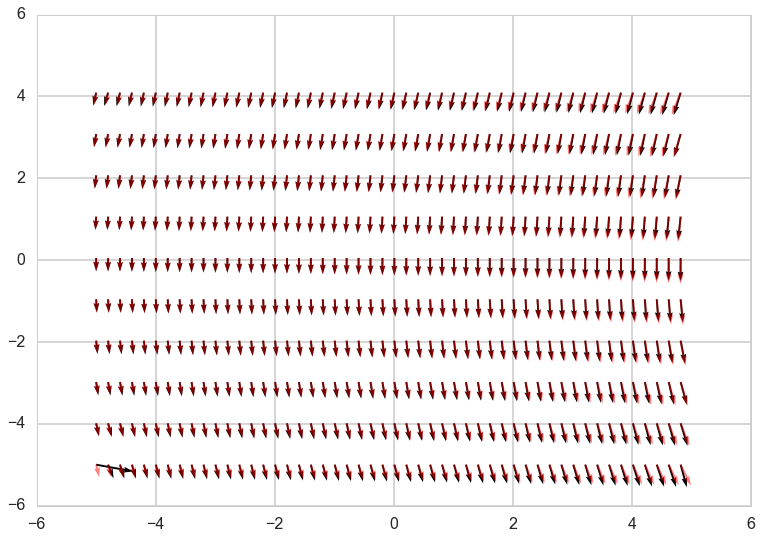

In [9]:
step = 10
plt.quiver(mesh[0][::step, ::step], mesh[1][::step, ::step], 
           B_x_solution[::step, ::step],
           B_y_solution[::step, ::step])
plt.quiver(mesh[0][::step,::step], mesh[1][::step, ::step], 
           B_x[::step, ::step],
           B_y[::step, ::step], color='red', alpha=0.5)

# Try in 3D

In [10]:
x = np.linspace(-5, 5, 30)
y = np.linspace(-5, 5, 20)
z = np.linspace(-5, 5, 10) 

mesh = np.meshgrid(x, y, z)
delta_x = x[1] - x[0]
delta_y = y[1] - y[0]
delta_z = z[1] - z[0]
rho_x = 1./delta_x
rho_y = 1./delta_y
rho_z = 1./delta_z

shape = mesh[0].shape

r = np.sqrt((mesh[0]-15)**2. + mesh[1]**2.)
current = 1.
wire_radius = 1.  
mu_0 = 1.
A_x = np.zeros(mesh[0].shape)
A_y = np.zeros(mesh[0].shape)
A_z = -current*mu_0/(2.*np.pi)*np.log(r/wire_radius) 

theta = np.arctan2(mesh[1], mesh[0] - 15.)
B_x = mu_0*current/(2.*np.pi*r)*np.sin(theta)*-1
B_y = mu_0*current/(2.*np.pi*r)*np.cos(theta)
B_z = np.zeros(mesh[0].shape)

In [11]:
rho = np.zeros(shape)
rho[:, 0, :] = 2.*delta_x*B_x[:, 0, :]
rho[:, -1, :] = -2.*delta_x*B_x[:, -1, :]
rho[0, :, :] = 2.*delta_y*B_y[0, :, :]
rho[-1, :, :] = -2.*delta_y*B_y[-1, :, :]
rho[:, :, 0] = 2.*delta_z*B_z[:, :, 0]
rho[:, :, -1] = -2.*delta_z*B_z[:, :, -1]

In [12]:
rhofft = np.zeros(shape, dtype=float)
for j in xrange(shape[0]):
    for k in xrange(shape[2]):
        rhofft[j,:,k] = fft.dct(rho[j,:,k], type=1)
for i in xrange(shape[1]):
    for k in xrange(shape[2]):
        rhofft[:,i,k] = fft.dct(rhofft[:,i,k], type=1)
for j in xrange(shape[0]):
    for i in xrange(shape[1]):
        rhofft[j,i,:] = fft.dct(rhofft[j,i,:], type=1)

In [13]:
rhofft_divided = np.array(rhofft)
for i in xrange(shape[1]):
    for j in xrange(shape[0]):
        for k in xrange(shape[2]):
            factor_cos_press = 2.0 * (np.cos((np.pi * i) /
                                      (shape[1] - 1)) + 
                                      np.cos((np.pi * j) /
                                      (shape[0] - 1)) +
                                      np.cos((np.pi * k) /
                                      (shape[2] - 1)) - 3.0)
        
            factor_sin_k = -1*(2*np.sin(np.pi*(i)/(2*(shape[1]-1))))**2
            factor_sin_l = -1*(2*np.sin(np.pi*(j)/(2*(shape[0]-1))))**2
            factor_sin_m = -1*(2*np.sin(np.pi*(k)/(2*(shape[2]-1))))**2
            factor_sin_fuka = factor_sin_k + factor_sin_l + factor_sin_m
       
            factor = factor_cos_press
            #print np.allclose(factor_cos_press, factor_sin_fuka)
            if factor != 0.0:
                rhofft_divided[j, i, k] /= factor
            else:
                rhofft_divided[j, i, k] = 0.0

In [14]:
solution = np.zeros(shape, dtype=float)
ifft_factor_x = 0.5/(shape[1] - 1.)
ifft_factor_y = 0.5/(shape[0] - 1.)
ifft_factor_z = 0.5/(shape[2] - 1.)
for j in xrange(shape[0]):
    for k in xrange(shape[2]):
        solution[j,:,k] = ifft_factor_x * fft.dct(rhofft_divided[j,:,k], 
                                                  type=1)
for i in xrange(shape[1]):
    for k in xrange(shape[2]):
        solution[:,i,k] = ifft_factor_y * fft.dct(solution[:,i,k], 
                                                  type=1)
for j in xrange(shape[0]):
    for i in xrange(shape[1]):
        solution[j,i,:] = ifft_factor_z * fft.dct(solution[j,i,:], 
                                                  type=1)
B_x_solution = np.gradient(solution, axis=1)*1./delta_x
B_y_solution = np.gradient(solution, axis=0)*1./delta_y
B_z_solution = np.gradient(solution, axis=2)*1./delta_z

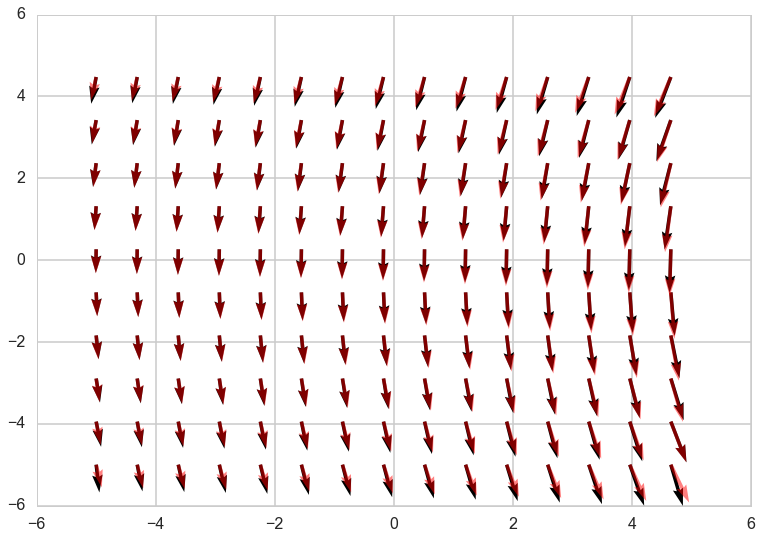

In [15]:
step = 2
z_plane = 5
plt.quiver(mesh[0][::step, ::step, z_plane], mesh[1][::step, ::step, z_plane], 
           B_x_solution[::step, ::step, z_plane],
           B_y_solution[::step, ::step, z_plane])
plt.quiver(mesh[0][::step,::step, z_plane], mesh[1][::step, ::step, z_plane], 
           B_x[::step, ::step, z_plane],
           B_y[::step, ::step, z_plane], color='red', alpha=0.5)

In [19]:
size = mesh[0].size
error = np.sum(np.sqrt((B_x - B_x_solution)**2.))/size
error += np.sum(np.sqrt((B_y - B_y_solution)**2.))/size
error += np.sum(np.sqrt((B_z - B_z_solution)**2.))/size
print error/3

0.000793557966844
